# Regression

*Approximate a function $f$ that maps from $\mathbb{R}^D$ to $\mathbb{R}^F$.*

**Model:**

* We assume that there is some **latent function** $f: \mathbb{R}^D \rightarrow \mathbb{R}^F$.
* We observe **samples** $(\boldsymbol{x}_n, \boldsymbol{y}_n)$ with $f(\boldsymbol{x}_n) + \boldsymbol{\epsilon}_n = \boldsymbol{y}_n$
* with i.i.d. noise, for example $\boldsymbol{\epsilon}_n \sim \mathcal{N}(0, \sigma^2 \boldsymbol{I}_F)$.

## Table of Contents

In this talk, you will learn about...

**Algorithms**

* Linear Regression
* Polynomial Regression
* Ridge Regression
* Kernel Regression
* Kernel Ridge Regression
* Gaussian Process Regression
* Support Vector Regression
* Neural Nets

**Tips**

* Bias vs. Variance
* Model Selection

## Dataset

All samples $\{(\boldsymbol{x}_1, \boldsymbol{y}_1), \ldots, (\boldsymbol{x}_N, \boldsymbol{y}_N)\}$ are called **dataset**.

Here is an example.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.utils import check_random_state


def generate_data(n_samples, sigma, random_state=None):
    random_state = check_random_state(random_state)
    x = np.linspace(0, 1, n_samples)
    X = x[:, np.newaxis]
    y_true = np.cos(2 * np.pi * x)
    y = y_true + sigma * random_state.randn(n_samples)
    return x, X, y_true, y

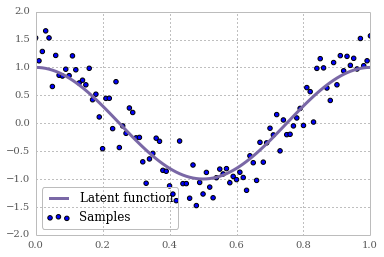

In [3]:
x, X, y_true, y = generate_data(101, 0.3, 0)
plt.plot(x, y_true, label="Latent function")
plt.scatter(x, y, label="Samples")
plt.xlim((0, 1))
plt.legend()

We will only consider the case $F = 1$.

In this case, we can organize the whole dataset in a **design matrix** $\boldsymbol{X} \in \mathbb{R}^{N \times D}$ which contains the input $\boldsymbol{x}_n$ of one sample in each row and a vector $\boldsymbol{y} \in \mathbb{R}^N$ that contains the output $y_n$ of one sample in each entry.

## Linear Regression

**Model:** We assume that there is some latent function $f: \mathbb{R}^D \rightarrow \mathbb{R}$. We observe samples $(\boldsymbol{x}_n, y_n)$ with $f(\boldsymbol{x}_n) + \epsilon_n = y_n$ and $\epsilon_n \sim \mathcal{N}(0, \sigma^2)$. Since we assume that $f$ is a linear function of the form $f(\boldsymbol{x}_n) = \boldsymbol{w} \boldsymbol{x}$ ($\boldsymbol{x}$ will be extended by 1 so that $\boldsymbol{w}$ incorporates a bias), we will learn by minimizing

$$\arg \min_\boldsymbol{w} \frac{1}{2} || \boldsymbol{y} - \boldsymbol{X} \boldsymbol{w} ||^2_2.$$

We can find a solution for the vector $\boldsymbol{w}$ by setting the derivative of the objective function to 0 and solving for $\boldsymbol{w}$.

\begin{eqnarray*}
&& 0 = \boldsymbol{X}^T \left( \boldsymbol{y} - \boldsymbol{X} \boldsymbol{w} \right) \boldsymbol{X} = \boldsymbol{X}^T \boldsymbol{y} - \boldsymbol{X}^T \boldsymbol{X} \boldsymbol{w}\\
&\Leftrightarrow& \boldsymbol{X}^T \boldsymbol{X} \boldsymbol{w} = \boldsymbol{X}^T \boldsymbol{y}\\
&\Leftrightarrow& \boldsymbol{w} = \left( \boldsymbol{X}^T \boldsymbol{X} \right)^{-1} \boldsymbol{X}^T \boldsymbol{y}
\end{eqnarray*}

(Now we actually have to prove that the second derivative is greater than 0.)

In [4]:
from sklearn.base import BaseEstimator, RegressorMixin


class LinearRegression(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        n_samples = X.shape[0]
        X_bias = np.hstack((np.ones((n_samples, 1)), X))
        self.w = np.linalg.inv(X_bias.T.dot(X_bias)).dot(X_bias.T).dot(y)
        return self

    def predict(self, X):
        n_samples = X.shape[0]
        X_bias = np.hstack((np.ones((n_samples, 1)), X))
        return X_bias.dot(self.w)

In [5]:
def plot_model(model):
    x, X, y_true, y = generate_data(101, 0.3, 0)
    plt.plot(x, y_true, label="Latent function")
    plt.scatter(x, y, label="Samples")
    plt.plot(x, model.predict(X), label="Prediction")
    plt.xlim((0, 1))
    plt.legend()

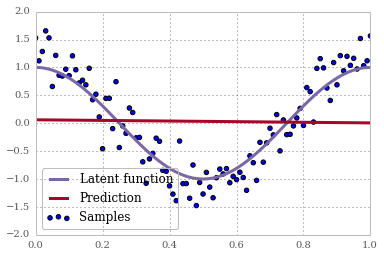

In [6]:
x, X, y_true, y = generate_data(101, 0.3, 0)
linreg = LinearRegression().fit(X, y)
plot_model(linreg)

**Problems:**

* linear model
* complexity of (pseudo-)inverse depends on number of features with $O(D^3)$
* alternative: we can use the iterative algorithm gradient descent which requires multiple iterations over the whole dataset

## Nonlinear Regression

We can extend the linear model to approximate nonlinear functions by

* using fixed nonlinear features (polynomial regression, radial basis function networks, ...)
* learning nonlinear features (neural nets)
* using nonlinear similarities (kernel methods)
* mixing multiple linear models (local regression)

## Polynomial Regression

We can approximate nonlinear functions with linear regression by generating nonlinear features $\phi(\boldsymbol{x})$.

In [7]:
from sklearn.preprocessing import PolynomialFeatures


class PolynomialRegression(BaseEstimator, RegressorMixin):
    def __init__(self, degree):
        self.degree = degree

    def fit(self, X, y):
        self.poly = PolynomialFeatures(degree=self.degree).fit(X)
        X_poly = self.poly.transform(X)
        self.w = np.linalg.pinv(X_poly.T.dot(X_poly)).dot(X_poly.T).dot(y)
        return self

    def predict(self, X):
        X_poly = self.poly.transform(X)
        return X_poly.dot(self.w)

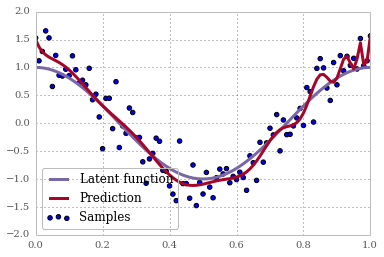

In [8]:
polyreg = PolynomialRegression(100).fit(X, y)
plot_model(polyreg)

**Problems:**

* overfitting
* features have to be selected
* does not address the cubic complexity

## Bias vs. Variance

In [9]:
def plot_bias_variance():
    plt.figure(figsize=(12, 12))
    def plot_target():
        t = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(t), np.sin(t))
        plt.plot(0.67 * np.cos(t), 0.67 * np.sin(t))
        plt.plot(0.33 * np.cos(t), 0.33 * np.sin(t))
        plt.scatter(0, 0, color="black", s=100)
    plt.setp(plt.subplot(2, 2, 1, aspect="equal"), xticks=(), yticks=())
    plot_target()
    plt.title("Low Variance")
    plt.ylabel("Low Bias")
    plt.scatter((np.random.rand(10)-0.5)*0.2, (np.random.rand(10)-0.5)*0.2, s=50)
    plt.setp(plt.subplot(2, 2, 2, aspect="equal"), xticks=(), yticks=())
    plot_target()
    plt.title("High Variance")
    plt.scatter((np.random.rand(10)-0.5)*0.8, (np.random.rand(10)-0.5)*0.8, s=50)
    plt.setp(plt.subplot(2, 2, 3, aspect="equal"), xticks=(), yticks=())
    plot_target()
    plt.ylabel("High Bias")
    plt.scatter((np.random.rand(10)-0.5)*0.2+0.5, (np.random.rand(10)-0.5)*0.2+0.5, s=50)
    plt.setp(plt.subplot(2, 2, 4, aspect="equal"), xticks=(), yticks=())
    plot_target()
    plt.scatter((np.random.rand(10)-0.5)*0.8+0.5, (np.random.rand(10)-0.5)*0.8+0.5, s=50)

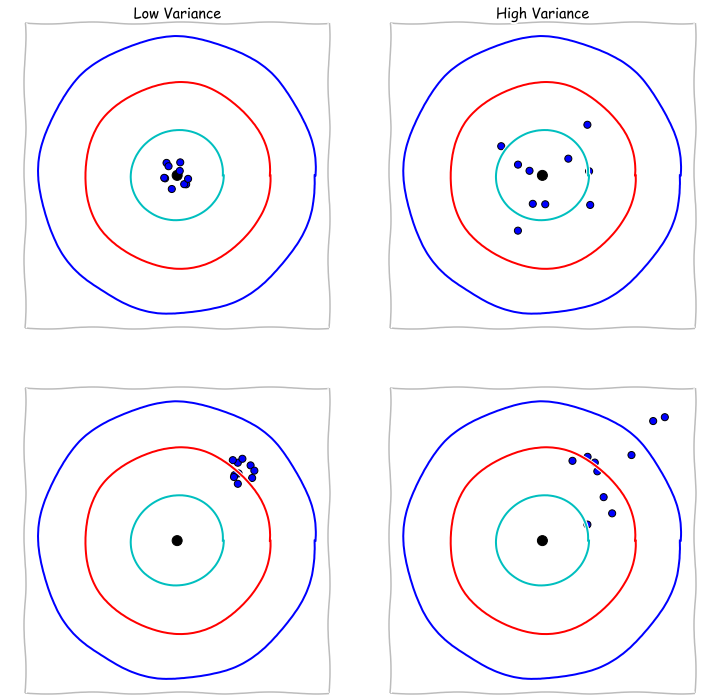

In [10]:
with plt.xkcd():
    plot_bias_variance()

In [11]:
def plot_bias_variance_error():
    plt.setp(plt.gca(), xticks=(), yticks=(), xlabel="Complexity", ylabel="Error")
    resolution = 100
    complexity = np.linspace(0, 4, resolution)
    noise_error = np.ones(resolution) * 0.1
    bias_error = np.exp(-complexity)
    variance_error = np.exp(complexity - np.max(complexity))
    plt.plot(complexity, bias_error, label="Bias")
    plt.plot(complexity, variance_error, label="Variance")
    plt.plot(complexity, noise_error, label="Noise")
    plt.plot(complexity, bias_error + variance_error + noise_error, label="Total")
    plt.legend(loc="best")

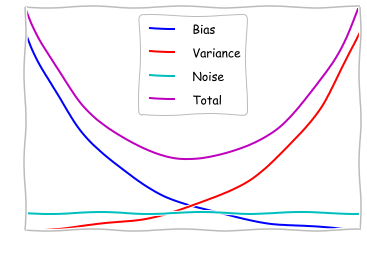

In [12]:
with plt.xkcd():
    plot_bias_variance_error()

## Ridge Regression

To reduce overfitting, we minimize

$$\arg \min_\boldsymbol{w} \frac{1}{2} || \boldsymbol{y} - \boldsymbol{X} \boldsymbol{w} ||^2_2 + \frac{\gamma}{2} \boldsymbol{w}^T \boldsymbol{w},$$

which means that we set a prior for $\boldsymbol{w}$.

\begin{eqnarray*}
&& 0
= \boldsymbol{X}^T \left( \boldsymbol{y} - \boldsymbol{X} \boldsymbol{w}^T \right) \boldsymbol{X} + \gamma \boldsymbol{w}
= \boldsymbol{X}^T \boldsymbol{y} - \boldsymbol{X}^T \boldsymbol{X} \boldsymbol{w} + \gamma \boldsymbol{w}\\
&\Leftrightarrow& \boldsymbol{X}^T \boldsymbol{X} \boldsymbol{w} + \gamma \boldsymbol{w} = \boldsymbol{X}^T \boldsymbol{y}\\
&\Leftrightarrow& \boldsymbol{w} = \left( \boldsymbol{X}^T \boldsymbol{X} + \gamma \boldsymbol{I} \right)^{-1} \boldsymbol{X}^T \boldsymbol{y}
\end{eqnarray*}

In [13]:
class PolynomialRidgeRegression(BaseEstimator, RegressorMixin):
    def __init__(self, degree, gamma):
        self.degree = degree
        self.gamma = gamma

    def fit(self, X, y):
        self.poly = PolynomialFeatures(degree=self.degree).fit(X)
        X_poly = self.poly.transform(X)
        self.w = (np.linalg.inv(X_poly.T.dot(X_poly) + self.gamma *
                                np.eye(X_poly.shape[1])).dot(X_poly.T).dot(y))
        return self

    def predict(self, X):
        X_poly = self.poly.transform(X)
        return X_poly.dot(self.w)

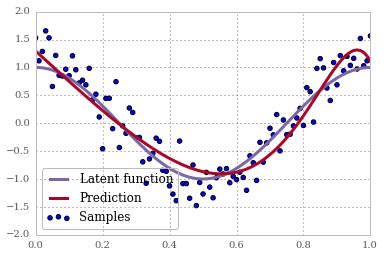

In [14]:
polyridgereg = PolynomialRidgeRegression(20, 0.1).fit(X, y)
plot_model(polyridgereg)

**Problems:**

* regularization coefficient has to be selected
* does not address the cubic complexity

## Kernel Regression

We can express $\boldsymbol{w}$ as a weighted sum of the training data
$$\boldsymbol{w} = \boldsymbol{X}^T \boldsymbol{\alpha}$$

Which leads to the **dual problem**
$$\arg \min_\boldsymbol{\alpha} \frac{1}{2} || \boldsymbol{y} - \boldsymbol{X} \boldsymbol{X}^T \boldsymbol{\alpha}||^2_2$$

We call $\boldsymbol{K} = \boldsymbol{X}\boldsymbol{X}^T \in \mathbb{R}^{N \times N}$ the Gram matrix so that we can find the minimum at
\begin{eqnarray*}
&& 0 = \boldsymbol{K} \boldsymbol{y} - \boldsymbol{K}\boldsymbol{K} \boldsymbol{\alpha}\\
&\Leftrightarrow& \boldsymbol{\alpha}
= \left( \boldsymbol{K}\boldsymbol{K} \right)^{-1} \boldsymbol{K} \boldsymbol{y}
= \boldsymbol{K}^{-1} \boldsymbol{y}
= \boldsymbol{K} \boldsymbol{y}
\end{eqnarray*}

Instead of the *linear kernel* $k(\boldsymbol{x}, \boldsymbol{x}') = \boldsymbol{x}^T \boldsymbol{x}'$, we can use any Mercer kernel to build the Gram matrix. The intuition behind this is that we use another definition of similarity when we use another kernel.

In [15]:
from sklearn.metrics.pairwise import pairwise_kernels


class KernelRegression(BaseEstimator, RegressorMixin):
    def __init__(self, kernel, **kernel_args):
        self.kernel = kernel
        self.kernel_args = kernel_args

    def fit(self, X, y):
        self.X = X
        K = pairwise_kernels(self.X, metric=self.kernel, **self.kernel_args)
        self.alpha = np.linalg.pinv(K).dot(y)
        return self

    def predict(self, X):
        K_star = pairwise_kernels(X, self.X, metric=self.kernel, **self.kernel_args)
        return K_star.dot(self.alpha)

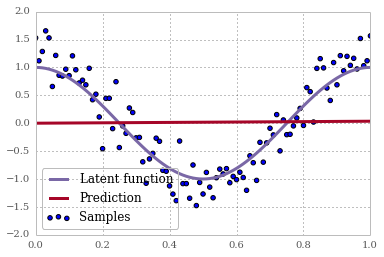

In [16]:
kernreg = KernelRegression("linear").fit(X, y)
plot_model(kernreg)

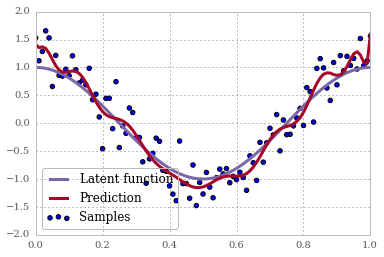

In [17]:
kernreg = KernelRegression("rbf", gamma=10.0).fit(X, y)
plot_model(kernreg)

**Problems:**

* overfitting
* kernel has to be selected (often less critical than features)
* complexity is with respect to number of samples is $O(N^3)$

## Kernel Ridge Regression

We start from ridge regression

$$\arg \min_\boldsymbol{w} \frac{1}{2} || \boldsymbol{y} - \boldsymbol{X} \boldsymbol{w} ||^2_2 + \frac{\gamma}{2} \boldsymbol{w}^T \boldsymbol{w}.$$

and replace again

$$\boldsymbol{w} = \boldsymbol{X}^T \boldsymbol{\alpha},$$

so that

$$\boldsymbol{w}^T \boldsymbol{w} = \left( \boldsymbol{X}^T \boldsymbol{\alpha} \right)^T \left( \boldsymbol{X}^T \boldsymbol{\alpha} \right) = \boldsymbol{\alpha}^T \boldsymbol{X} \boldsymbol{X}^T \boldsymbol{\alpha} = \boldsymbol{\alpha}^T \boldsymbol{K} \boldsymbol{\alpha},$$

which results in a modification of the dual problem

$$\arg \min_\boldsymbol{w} \frac{1}{2} || \boldsymbol{y} - \boldsymbol{K} \boldsymbol{\alpha} ||^2_2 + \frac{\gamma}{2} \boldsymbol{\alpha}^T \boldsymbol{K} \boldsymbol{\alpha}.$$

\begin{eqnarray*}
&& 0
= \boldsymbol{K} \left( \boldsymbol{y} - \boldsymbol{K} \boldsymbol{\alpha} \right) + \gamma \boldsymbol{K} \boldsymbol{\alpha}
= \boldsymbol{K} \boldsymbol{y} - \boldsymbol{K} \boldsymbol{K} \boldsymbol{\alpha} + \gamma \boldsymbol{K} \boldsymbol{\alpha}\\
&\Leftrightarrow& \boldsymbol{K} \boldsymbol{y} = \boldsymbol{K} \boldsymbol{K} \boldsymbol{\alpha} - \gamma \boldsymbol{K} \boldsymbol{\alpha}\\
&\Leftrightarrow& \boldsymbol{y} = \boldsymbol{K} \boldsymbol{\alpha} - \gamma \boldsymbol{I} \boldsymbol{\alpha}\\
&\Leftrightarrow& \left(\boldsymbol{K} - \gamma \boldsymbol{I} \right)^{-1} \boldsymbol{y} = \boldsymbol{\alpha}
\end{eqnarray*}

In [18]:
class KernelRidgeRegression(BaseEstimator, RegressorMixin):
    def __init__(self, kernel, lmbda, **kernel_args):
        self.kernel = kernel
        self.lmbda = lmbda
        self.kernel_args = kernel_args

    def fit(self, X, y):
        self.X = X
        K = pairwise_kernels(self.X, metric=self.kernel, **self.kernel_args)
        self.alpha = np.linalg.pinv(K + self.lmbda * np.eye(X.shape[0])).dot(y)
        return self

    def predict(self, X):
        K_star = pairwise_kernels(X, self.X, metric=self.kernel, **self.kernel_args)
        return K_star.dot(self.alpha)

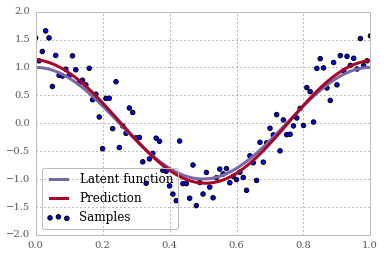

In [19]:
kernridgereg = KernelRidgeRegression("rbf", lmbda=1.0, gamma=10.0).fit(X, y)
plot_model(kernridgereg)

## Gaussian Process Regression

Kernels that are used for GPR (covariance functions) usually have many more hyperparameters than kernels that we have been looking at before. However, the hyperparameter optimization of GPR is much better than other methods (but more computationally complex).

The log-likelihood
$$\log p(\boldsymbol{y}|\boldsymbol{X}) = - \frac{1}{2} \boldsymbol{y} \boldsymbol{K}^{-1} \boldsymbol{y} - \frac{1}{2} \log |\boldsymbol{K}| - \frac{N}{2} \log (2 \pi)$$
will be minimized with respect to the kernel's hyperparameters $\boldsymbol{\theta}$. The derivative can be computed as
$$\frac{\partial}{\partial \theta_j} \log p(\boldsymbol{y}|\boldsymbol{X}) = \frac{1}{2} tr \left( (\boldsymbol{\alpha} \boldsymbol{\alpha}^T - \boldsymbol{K}^{-1}) \frac{\partial \boldsymbol{K}}{\partial \theta_j} \right)$$

In [20]:
from scipy import linalg, optimize
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.gaussian_process import correlation_models as correlation


def l1_cross_distances(X):
    n_samples, n_features = X.shape
    n_nonzero_cross_dist = n_samples * (n_samples - 1) // 2
    ij = np.zeros((n_nonzero_cross_dist, 2), dtype=np.int)
    D = np.zeros((n_nonzero_cross_dist, n_features))
    ll_1 = 0
    for k in range(n_samples - 1):
        ll_0 = ll_1
        ll_1 = ll_0 + n_samples - k - 1
        ij[ll_0:ll_1, 0] = k
        ij[ll_0:ll_1, 1] = np.arange(k + 1, n_samples)
        D[ll_0:ll_1] = np.abs(X[k] - X[(k + 1):n_samples])
    return D, ij


def kernel(X, Y=None, theta=None):
    dx = manhattan_distances(X, Y, sum_over_features=False)
    n_samples = X.shape[0]
    n_eval = dx.shape[0] / n_samples
    return correlation.squared_exponential(theta, dx).reshape(n_eval, n_samples)


class GaussianProcessRegression(BaseEstimator, RegressorMixin):
    def __init__(self, nugget):
        self.nugget = nugget

    def fit(self, X, y):
        self.n_samples, self.n_features = X.shape
        self.X = X
        self.y = y
        self.D, self.ij = l1_cross_distances(X)
        self.theta_, _, par = self._optimize_theta()
        self.__dict__.update(par)
        return self

    def predict(self, X, eval_MSE=False):
        K = kernel(X, self.X, self.theta_)
        y = np.dot(K, self.alpha)
        if eval_MSE:
            Kt = linalg.solve_triangular(self.L, K.T, lower=True)
            MSE = np.dot(self.sigma2, (1 - (Kt ** 2).sum(axis=0))[np.newaxis])
            MSE = np.sqrt((MSE ** 2).sum(axis=0))
            return y, MSE
        else:
            return y

    def reduced_likelihood(self, theta):
        k = correlation.squared_exponential(theta, self.D)
        K = np.eye(self.n_samples) * (1. + self.nugget)
        K[self.ij[:, 0], self.ij[:, 1]] = k
        K[self.ij[:, 1], self.ij[:, 0]] = k
        try:
            L = linalg.cholesky(K, lower=True)
        except linalg.LinAlgError:
            return -np.inf, {}
        Ly = linalg.solve_triangular(L, self.y, lower=True)
        alpha = linalg.solve_triangular(L.T, Ly)
        sigma2 = (Ly ** 2.).sum() / self.n_samples
        log_K_det = (np.diag(L) ** (2. / self.n_samples)).prod()
        objective = -sigma2 * log_K_det
        return objective, {"L": L, "alpha": alpha, "sigma2": sigma2}

    def _optimize_theta(self):
        def objective(log10t):
            return -self.reduced_likelihood(theta=10 ** log10t)[0]

        constraints = reduce(lambda x, y: x + y,
                             [(lambda log10t, i=i: log10t[i] - 1e-10,
                               lambda log10t, i=i: 1e+10 - log10t[i])
                              for i in range(self.n_features)])

        log10_optimal_theta = optimize.fmin_cobyla(
            objective, np.log10(np.ones((1, self.n_features))), constraints, iprint=0)
        optimal_theta = 10. ** log10_optimal_theta
        optimal_rlf_value, optimal_par = self.reduced_likelihood(
            theta=optimal_theta)

        return optimal_theta, optimal_rlf_value, optimal_par

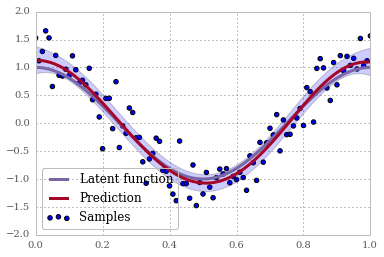

In [21]:
gpreg = GaussianProcessRegression(nugget=1.0).fit(X, y)
plot_model(gpreg)
y_pred, y_mse = gpreg.predict(X, eval_MSE=True)
plt.fill_between(x, y_pred - 2 * np.sqrt(y_mse), y_pred + 2 * np.sqrt(y_mse), alpha=0.2)

**Problems:**

* does not address the cubic complexity

## Loss Function

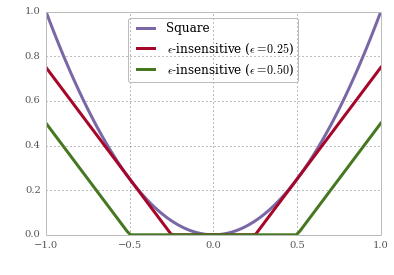

In [22]:
square_loss = lambda d: d ** 2
epsilon_insensitive = lambda d, epsilon: np.maximum(0.0, np.abs(d) - epsilon)

d = np.linspace(-1, 1, 100)
plt.plot(d, square_loss(d), label="Square")
plt.plot(d, epsilon_insensitive(d, epsilon=0.25),
         label="$\epsilon$-insensitive ($\epsilon=0.25$)")
plt.plot(d, epsilon_insensitive(d, epsilon=0.5),
         label="$\epsilon$-insensitive ($\epsilon=0.50$)")
plt.legend(loc="upper center")
plt.xlabel("Prediction - Sample")
plt.ylabel("Loss")

## Support Vector Regression

Support vector algorithms usually have constrained optimization problem. In this case, we want to optimize

$\arg \min_{\boldsymbol{w}} \frac{1}{2} ||\boldsymbol{w}||^2$ subject to $\begin{cases}
y_i - \boldsymbol{w}_i^T \boldsymbol{x}_i - b \leq \epsilon\\
\boldsymbol{w}_i^T \boldsymbol{x}_i + b - y_i \leq \epsilon\\
\end{cases}$.

In comparison to kernel ridge regression, this will result in only a few **support vectors** that will be used for predictions instead of the whole training set.

![SVR](files/svr.gif)
Source: http://research.ncku.edu.tw/re/articles/e/20080620/3.html

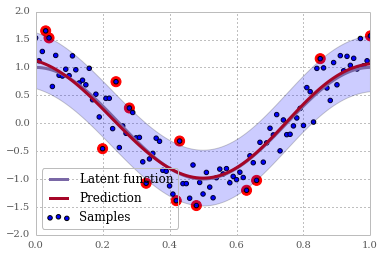

In [23]:
from sklearn.svm import SVR

svr = SVR("rbf", epsilon=0.5, gamma=10.0).fit(X, y)
plt.scatter(x[svr.support_], y[svr.support_], color="r", s=100)
plot_model(svr)
plt.fill_between(x, svr.predict(X) - svr.epsilon,
                 svr.predict(X) + svr.epsilon, alpha=0.2)

**Problems:**

* epsilon and kernel have to be selected

## Neural Nets

* A neural net is an interconnected assembly of neurons.
* Each neuron behaves like a linear model with a nonlinear activation function.
* Learning is complicated and involves optimizing a non-convex objective.

![ANN](ann.png)
Source: http://en.wikipedia.org/wiki/File:Neural_network_example.png

In [24]:
from openann import Net, Activation, DataSet, LMA


class NeuralNet(BaseEstimator, RegressorMixin):
    def __init__(self, n_nodes, gamma=0.0):
        self.n_nodes = n_nodes
        self.gamma = gamma

    def fit(self, X, y):
        n_features = X.shape[1]
        self.net = Net()
        self.net.set_regularization(0.0, self.gamma, 0.0)
        self.net.input_layer(n_features)
        self.net.fully_connected_layer(self.n_nodes, Activation.LOGISTIC)
        self.net.output_layer(1, Activation.LINEAR)
        Y = y.reshape(len(X), 1)
        dataset = DataSet(X, Y)
        lma = LMA({"minimal_value_differences": 1e-8})
        lma.optimize(self.net, dataset)
        return self

    def predict(self, X):
        return self.net.predict(X).ravel()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


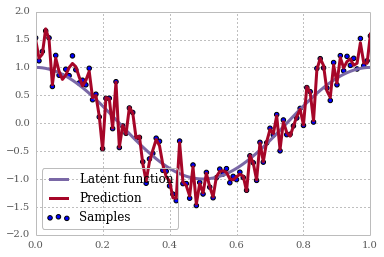

In [25]:
net = NeuralNet(100).fit(X, y)
plot_model(net)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


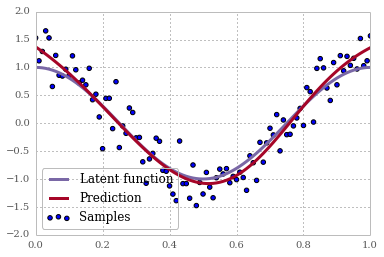

In [26]:
net = NeuralNet(100, gamma=1e-4).fit(X, y)
plot_model(net)

**Problems:**

* topology, regularization coefficients, optimization algorithm have to be selected
* non-convex optimization

## Comparison

In [27]:
def generate_data_1(n_samples, sigma, random_state=None):
    random_state = check_random_state(random_state)
    x = np.linspace(0, 1, n_samples)
    X = x[:, np.newaxis]
    y_true = np.cos(4 * np.pi * x) + 2 * x
    y = y_true + sigma * random_state.randn(n_samples)
    return x, X, y_true, y

def generate_data_2(n_samples, sigma, random_state=None):
    random_state = check_random_state(random_state)
    x = np.linspace(0, 1, n_samples)
    X = x[:, np.newaxis]
    y_true = (4 * x - 1.0) ** 2
    y = y_true + sigma * random_state.randn(n_samples)
    return x, X, y_true, y

def generate_data_3(n_samples, sigma, random_state=None):
    random_state = check_random_state(random_state)
    x = np.linspace(0, 1, n_samples)
    X = x[:, np.newaxis]
    y_true = 5.0 * x
    y_true[x < 0.5] -= 3.0
    y = y_true + sigma * random_state.randn(n_samples)
    return x, X, y_true, y

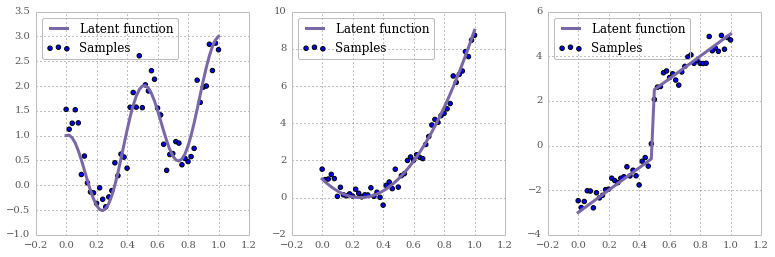

In [28]:
plt.figure(figsize=(13, 4))
for i, gen_data in enumerate([generate_data_1, generate_data_2, generate_data_3]):
    plt.subplot(1, 3, 1 + i)
    x, X, y_true, y = gen_data(51, 0.3, 0)
    plt.plot(x, y_true, label="Latent function")
    plt.scatter(x, y, label="Samples")
    plt.legend(loc="upper left")

In [29]:
def plot_model(model):
    plt.figure(figsize=(13, 4))
    for j, gen_data in enumerate([generate_data_1, generate_data_2, generate_data_3]):
        plt.subplot(1, 3, 1 + j)
        x, X, y_true, y = gen_data(51, 0.3, 0)
        plt.plot(x, y_true, label="Latent function")
        plt.scatter(x, y, label="Samples")
        model.fit(X, y)
        plt.plot(x, model.predict(X), label="Prediction")
        plt.legend(loc="upper left")

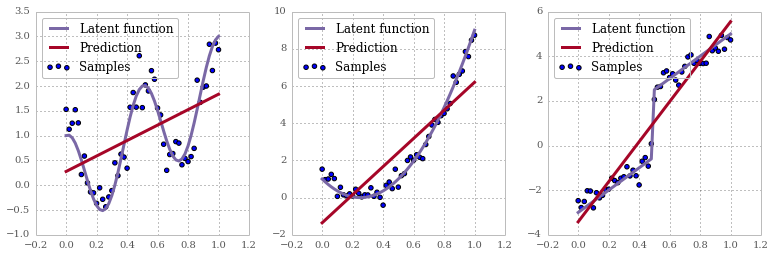

In [30]:
plot_model(LinearRegression())

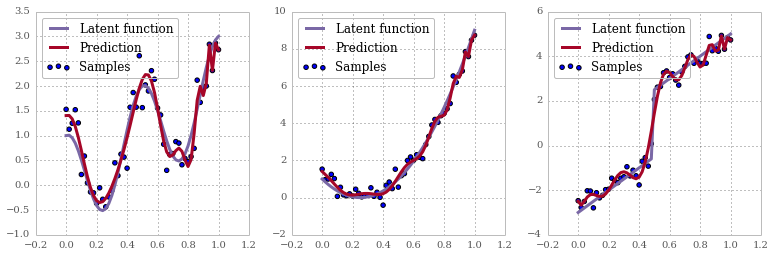

In [31]:
plot_model(PolynomialRegression(100))

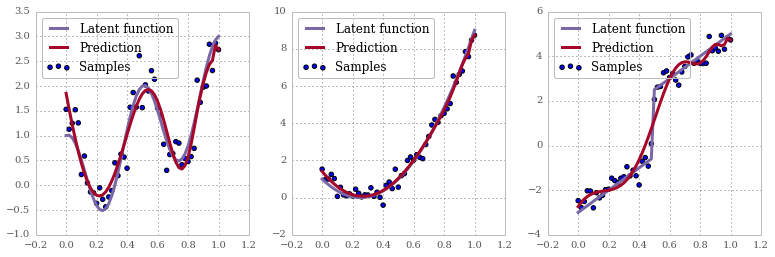

In [32]:
plot_model(PolynomialRidgeRegression(100, gamma=1e-5))

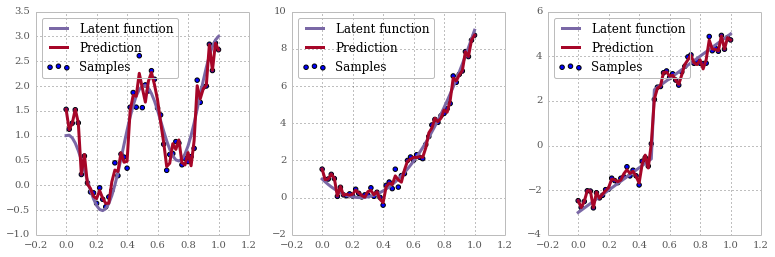

In [33]:
plot_model(KernelRegression("rbf", gamma=100.0))

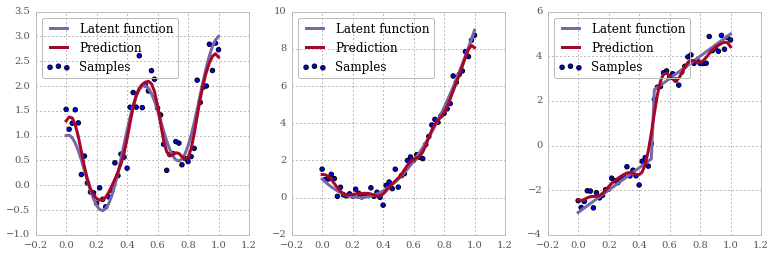

In [34]:
plot_model(KernelRidgeRegression("rbf", lmbda=0.1, gamma=100.0))

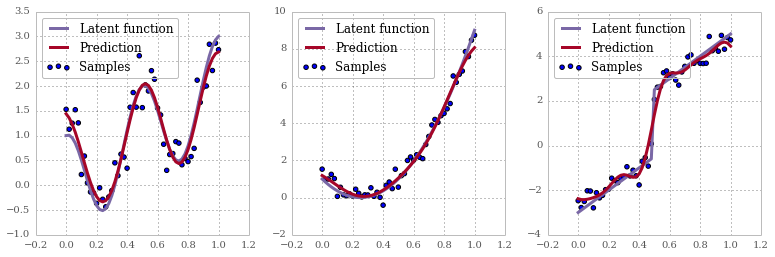

In [35]:
plot_model(GaussianProcessRegression(nugget=0.1))

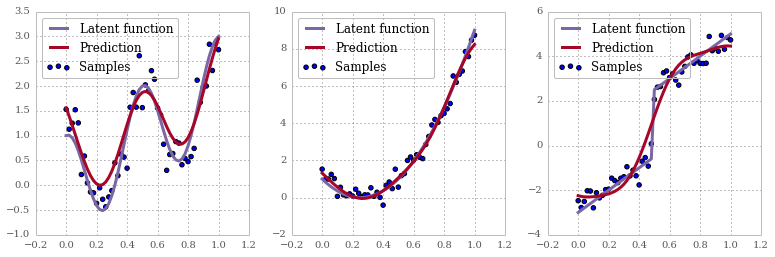

In [36]:
plot_model(SVR("rbf", epsilon=0.5, gamma=10.0, C=10.0))

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


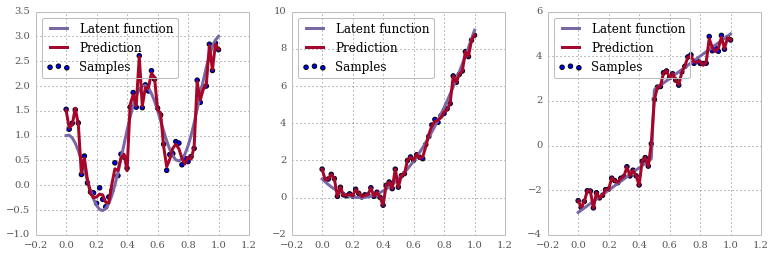

In [37]:
plot_model(NeuralNet(50))

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


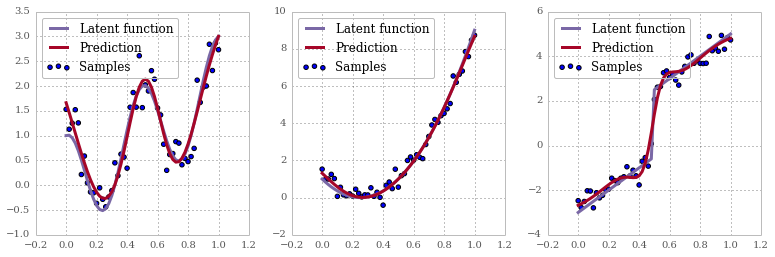

In [38]:
plot_model(NeuralNet(50, gamma=1e-4))

## Model Selection

**How can I evaluate my result?**

Appropriate metrics for regression are e.g.
* Mean squared error: $\frac{1}{N} \sum_n \left( \hat{y}_n - y_n \right)^2$
* [Coefficient of determination](http://en.wikipedia.org/wiki/Coefficient_of_determination) ($R^2$)

**What is the best model for me?**

That depends on...
* the number of samples
* the number of features
* the complexity of the latent function
* are we learning online?

**How do we select appropriate parameters?**

* Grid search + cross-validation
* Bayesian optimization + validation set

**Do I have enough samples? Is my model complex enough?**

In [39]:
from IPython.display import HTML
HTML('<iframe src=http://scikit-learn.org/stable/auto_examples/plot_validation_curve.html width=720 height=350></iframe>')

In [40]:
from IPython.display import HTML
HTML('<iframe src=http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html width=720 height=350></iframe>')

## More Topics

* [Generalized linear models](http://en.wikipedia.org/wiki/Generalized_linear_model)
* [Bayesian regression](http://en.wikipedia.org/wiki/Bayesian_linear_regression)
* [SVR tutorial](http://alex.smola.org/papers/2003/SmoSch03b.pdf)
* [Regression with decision trees](http://scikit-learn.org/stable/modules/tree.html#tree-regression)
* [Ensemble learning](http://en.wikipedia.org/wiki/Ensemble_learning)
* ...